# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import mlflow
import pickle

from sklearn import metrics as metrics_sklearn

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Méthodes

### Méthodes pour les datas

In [5]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [6]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [7]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [9]:
def clean_text(X):
    X = X.split()
    X_wo_arobas = [x for x in X if not x.startswith("@")]
    X_new = [x for x in X_wo_arobas if not x.startswith("http")]
    return ' '.join(X_new)

In [10]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [11]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [12]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [13]:
def clean_textism(sentence):
    neo_sentence = []
    for word in sentence:
        if word == 'u':
            neo_sentence.append('you')
        elif word == 'r':
            neo_sentence.append('are')
        elif word == 'ur':
            neo_sentence.append('your')
        elif word == 'some1':
            neo_sentence.append('someone')
        elif word == 'yrs':
            neo_sentence.append('years')
        elif word == 'hrs':
            neo_sentence.append('hours')
        elif word == 'mins':
            neo_sentence.append('minutes')
        elif word == 'secs':
            neo_sentence.append('seconds')
        elif word == 'pls' or word == 'plz':
            neo_sentence.append('please')
        elif word == '2morow':
            neo_sentence.append('tomorrow')
        elif word == '2day':
            neo_sentence.append('today')
        elif word == '2nite':
            neo_sentence.append('tonight')
        elif word == '4got' or word == '4gotten':
            neo_sentence.append('forget')
        elif word == 'amp' or word == 'quot' or word == 'lt' or word == 'gt' or word == '½25':
            neo_sentence.append('')
        else:
            neo_sentence.append(word)
    return neo_sentence

In [14]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():        
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        tk = tokenize.TweetTokenizer(reduce_len=True)
        temp_res = tk.tokenize(temp_res)
        
        # clean the sms language to usefull langage
        temp_res = clean_textism(temp_res)
        
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
        else:
            print("stem or lemma only")
            
        result.append(temp_res)
    return result

In [15]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # supprimer des mots spécifiques à twitter (commençant par @ et hhtp)
    df[col] = df[col].apply(clean_text)
    
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

### Méthodes pour BOW and Word Embedding

In [16]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [17]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
def representation_by_doc2vec(corpus):
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]
    return X

### Méthodes pour les métriques

In [18]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None, specifity=False):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics_sklearn.confusion_matrix(actual_class, predict_class)#, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    displ = metrics_sklearn.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()
    
    # compute specificity
    if specifity:
        speci = cm[0, 0]/(cm[0, 0] + cm[1, 0])
        print("Spécificité :", speci)
        return speci
    
    return False

In [19]:
def plot_roc_curve(model_name, y_val, y_val_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics_sklearn.roc_curve(y_val, y_val_pred)#, pos_label=1)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [20]:
def display_classification_metrics(estimator, y_val, y_val_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    print("Calcul et affichage des différentes métriques")
    result = {}
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics_sklearn.accuracy_score(y_val, y_val_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics_sklearn.precision_score(y_val, y_val_pred, average='macro').round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics_sklearn.recall_score(y_val, y_val_pred, average='macro').round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics_sklearn.roc_auc_score(y_val, y_val_pred, average='macro').round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(type(estimator).__name__, y_val, y_val_pred)
        elif met == "f1":   
            te_res = metrics_sklearn.f1_score(y_val, y_val_pred, average='macro').round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics_sklearn.fbeta_score(y_val, y_val_pred, beta=beta, average='macro').round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)
        else:
            print("La métrique", met, "n'est pas dans la liste suivante accuracy, recall, precision, auc, f1 et fbeta. Veuillez vérifier la saisie.")
        result[met] = te_res
    return result

In [21]:
from sklearn import metrics
def display_classification_report(y_true, y_pred, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(y_true, y_pred, target_names=display_labels)
    print(clf_report)

### Méthodes pour les modèles de régression

In [22]:
from sklearn import naive_bayes
def get_naive_bayes_model(model_name="gaussian"):
    """return an instance of the model selected
    
    Parameters:
    model_name (str) : names of naive bayes model used
    
    Returns:
    instance of the model
    """
    if model_name == "gaussian":
        return naive_bayes.GaussianNB()
    elif model_name == "multinomial":
        return naive_bayes.MultinomialNB()
    elif model_name == "bernoulli":
        return naive_bayes.BernoulliNB()
    else:
        return -1

### Méthodes pour les Réseaux de neurones

In [23]:
from keras.preprocessing import text
def tokenize_corpus(corpus):
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

In [24]:
def word_embedding_by_word2vec(embed_dim, data):
    w2v_model = Word2Vec(data, vector_size=embed_dim, workers=8)
    # w2v_model.build_vocab(data)
    w2v_model.train(data, total_examples=len(data), epochs=50)
    return w2v_model

In [25]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip data/glove.twitter.27B.zip
def word_embedding_by_glove(corpus):
    GLOVE_EMB = 'glove.twitter.27B.200d.txt'
      
    # compute embeddings index from GloVe
    embeddings_index = {}
    f = open(GLOVE_EMB)
    for line in f:
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' %len(embeddings_index))
    return embeddings_index   

In [26]:
def compute_corpus_to_word_embedding(corpus, model_name="word2vec"):
    tokenizer = tokenize_corpus(corpus)
    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1  
    
    if model_name == "word2vec":
        embed_dim = 800
        
        # word embedding using Word2Vec
        w2v_model = word_embedding_by_word2vec(embed_dim, corpus)
        word_index = w2v_model.wv.key_to_index
        # vocab_size = len(word_index)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in tokenizer.word_index.items():
            if w2v_model.wv.__contains__(word):
                embedding_matrix[i] = w2v_model.wv.__getitem__(word)
    elif model_name == "glove":
        embed_dim = 200
        
        # word embedding using GloVe
        embeddings_index = word_embedding_by_glove(corpus)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    print("Embedding Matrix Shape:", embedding_matrix.shape)
    return embedding_matrix, tokenizer, embed_dim

In [27]:
import keras.backend as K
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [28]:
def display_result_plot(history):
    spec,  val_spec  = history.history['specificity'], history.history['val_specificity']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training spec')
    plt.plot(epochs, val_spec, 'r', label='Validation spec')
    plt.title('Training and validation specificity')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [29]:
def display_result_plot_auc(history):
    spec,  val_spec  = history.history['auc'], history.history['val_auc']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training AUC')
    plt.plot(epochs, val_spec, 'r', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [30]:
def create_neural_network_model(embedding_layer, init_scheme="ones"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [31]:
def create_neural_network_model_auc(embedding_layer, init_scheme="ones"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.AUC()])
    model.summary()
    
    return model

In [32]:
def train_neural_network_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=1024):
    # on crée les méthodes de callback permettant d'arrêter l'entraînement dès que certaines conditions sont remplies
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=0),
        EarlyStopping(monitor='val_specificity', min_delta=1e-4, patience=10)
    ]
 
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val), callbacks=callbacks,
                        verbose=1)
    
    return history

In [33]:
def train_neural_network_model_auc(model, X_train, y_train, X_val, y_val):
    # on crée les méthodes de callback permettant d'arrêter l'entraînement dès que certaines conditions sont remplies
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=0),
        EarlyStopping(monitor='val_auc', min_delta=1e-4, patience=10)
    ]
 
    history = model.fit(X_train, y_train, batch_size=1024, epochs=30,
                        validation_data=(X_val, y_val), callbacks=callbacks,
                        verbose=1)
    
    return history

# Preparing dataset

In [34]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", sep=',',
                   encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [35]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [36]:
data["target"].replace(4, 1, inplace=True)

,%,%_cumul
label,,
0,50.0,50.0
1,50.0,100.0


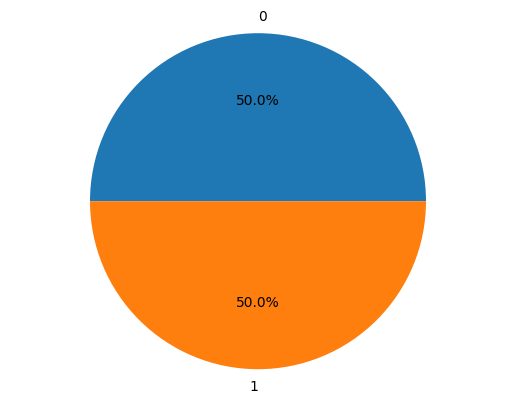

,%,%_cumul
label,,
0,50.0,50.0


In [37]:
show_unique_values(data, "target")

Sentiment du tweet 0 pour négatif et 4 pour positif  
Dans tous les cas, nous n'avons besoin que du texte du tweet et de la target

In [38]:
data.drop(columns=["id", "date", "flag", "user"], inplace=True)

In [39]:
print("The dataset is containing", data.shape[0], "lines and", data.shape[1], "columns.")

The dataset is containing 1600000 lines and 2 columns.


On commence par prendre un échantillon des données dans un premier temps : 10 000 de chaque target.

In [40]:
data_words = data.groupby(['target']).apply(pd.DataFrame.sample, n=10000, replace=True, random_state=42).reset_index(drop=True)

In [41]:
print("The sample dataset is containing", data_words.shape[0], "lines and", data_words.shape[1], "columns.")

The sample dataset is containing 20000 lines and 2 columns.


In [42]:
data_words.head()

,target,text
0,0,@ home studying for maths wooot ! im so going ...
1,0,Pickin up @misstinayao waitin on @sadittysash ...
2,0,@ProudGamerTweet I rather average 32370
3,0,"@ddlovato I'm trying to reach my dreams, but i..."
4,0,this song's middle change just doesn't want to...


In [43]:
negative_ex = data_words.query("target == 0")

In [44]:
negative_ex['text'].iloc[0]

'@ home studying for maths wooot ! im so going to fail this shit '

In [45]:
positive_ex = data_words.query("target == 1")

In [46]:
positive_ex['text'].iloc[2]

'@ashlili LIKE MEEEEEEEEE '

# Preprocessing

Il y a un total de 17694 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 0 fois et moins de 999 fois. Il reste alors 17687 mots différents dans tout le corpus.



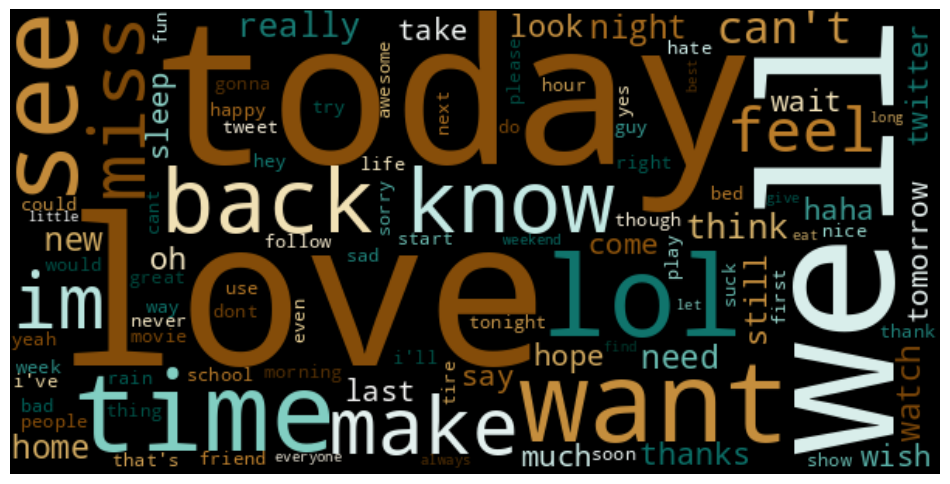

In [47]:
words_to_exclude = [
    "...", ".."
]
tags_to_remove=["NNP", "VBG", "VBN", "CD"]

corpus = natural_language_processing(
    data_words, "text", stem_or_lemma="lemma", debug=False, word_cloud=True,
    tags_to_remove=tags_to_remove, words_to_exclude=words_to_exclude)

In [48]:
data_words.head()

,filtexcl_words,filtpos_text,preproc_text,target,text
0,"[home, study, math, wooot, im, go, fail, shit]","[home, study, math, wooot, im, go, fail, shit]","[home, study, math, wooot, im, go, fail, shit]",0,home studying for maths wooot ! im so going to...
1,"[pickin, waitin, hurry, odeee, miss, dem, tabl...","[pickin, waitin, hurry, ..., odeee, miss, dem,...","[pickin, waitin, 2, hurry, ..., odeee, miss, d...",0,Pickin up waitin on 2 hurry up...I odeeee miss...
2,"[rather, average]","[rather, average]","[rather, average, 32370]",0,I rather average 32370
3,"[i'm, try, reach, dream, seem, impossible, adv...","[i'm, try, reach, dream, seem, impossible, adv...","[i'm, try, reach, dream, seem, impossible, adv...",0,"I'm trying to reach my dreams, but it seems im..."
4,"[song's, middle, change, want, born, arghhh]","[song's, middle, change, want, born, ..., arghhh]","[song's, middle, change, want, born, ..., arghhh]",0,this song's middle change just doesn't want to...


In [49]:
# drop des colonnes inutiles
data_words.drop(columns=["filtpos_text", "preproc_text", "text"], inplace=True)

In [50]:
def join_back(text):
    return ' '.join(text)

data_words['sentence'] = data_words['filtexcl_words'].apply(join_back)
data_words.rename(columns={"filtexcl_words": "list_words"}, inplace=True)

In [51]:
data_words.head()

,list_words,target,sentence
0,"[home, study, math, wooot, im, go, fail, shit]",0,home study math wooot im go fail shit
1,"[pickin, waitin, hurry, odeee, miss, dem, tabl...",0,pickin waitin hurry odeee miss dem table talk ...
2,"[rather, average]",0,rather average
3,"[i'm, try, reach, dream, seem, impossible, adv...",0,i'm try reach dream seem impossible advice
4,"[song's, middle, change, want, born, arghhh]",0,song's middle change want born arghhh


# Approche modèles sur mesure simple

Utilisation du bag of words pour le test des modèles sur mesure simple

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=800)# vectorizing words and storing in variable X(predictor)
X = cv.fit_transform(data_words["sentence"]).toarray()
print(X.shape)
y = data_words.target.values# y size
print(y.shape)

(20000, 800)
(20000,)


In [53]:
pickle.dump(cv, open("models/count_vectorizer.h5", 'wb'))

In [54]:
# 3 parties : train 60%, validation 20% and test 20%
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

### Test des 3 Naive Bayes models

In [55]:
for nb_model in ["gaussian", "multinomial", "bernoulli"]:
    model = get_naive_bayes_model(nb_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False)

Calcul et affichage des différentes métriques
Précision : 0.68
AUC : 0.661
Calcul et affichage des différentes métriques
Précision : 0.728
AUC : 0.728
Calcul et affichage des différentes métriques
Précision : 0.741
AUC : 0.739


Bernoulli est le meilleur comme model de référence

### Test avec Naive Bayes Bernoulli

In [56]:
y_pred

array([0, 1, 0, ..., 1, 1, 0])

Calcul et affichage des différentes métriques
Précision : 0.741
AUC : 0.739
Calcul et affichage de la courbe ROC
Execution time is: 0.0 s, soit 0.0 min, soit 0.0 h.


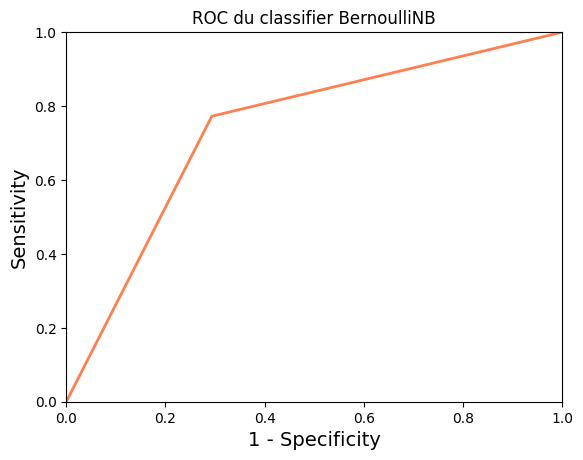

In [57]:
start = time.time()
model = get_naive_bayes_model("bernoulli")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=True)
end = time.time()
delta = round(end - start, 0)
print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

Calcul et affichage de la matrice de confusion


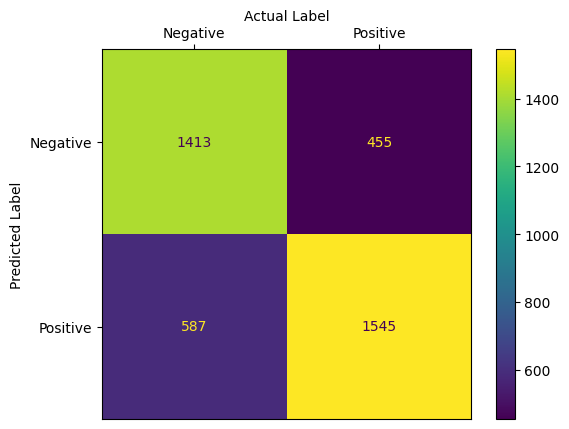

Spécificité : 0.7065


In [58]:
speci_bayes = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)

In [60]:
pickle.dump(model, open("models/mod_bernoulli.h5", 'wb'))

In [61]:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)

Notre référence sera donc une spécificité à 0.5965.

### Test avec XGBoost

In [62]:
from sklearn import ensemble

Calcul et affichage des différentes métriques
Précision : 0.739
AUC : 0.706
Calcul et affichage de la courbe ROC
Execution time is: 20.0 s, soit 0.0 min, soit 0.0 h.


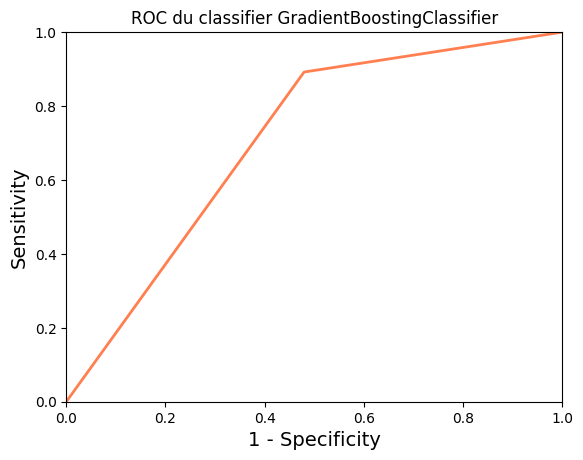

In [63]:
start = time.time()
model_xgb = ensemble.GradientBoostingClassifier(random_state=42)
# model_xgb = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
res_xgb = display_classification_metrics(model_xgb, y_test, y_pred_xgb, list_metrics=["precision", "auc"], roc_curve=True)
end = time.time()
delta = round(end - start, 0)
print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

Calcul et affichage de la matrice de confusion


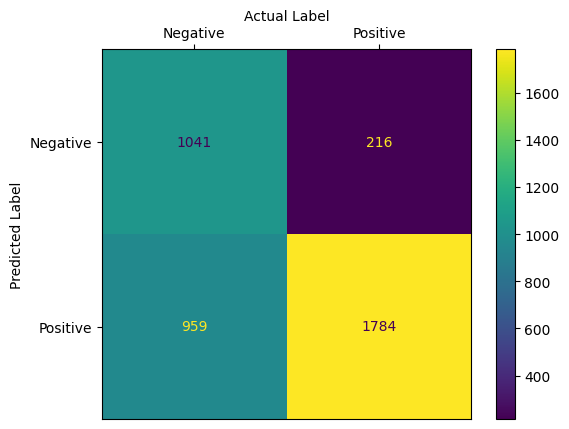

Spécificité : 0.5205


In [64]:
speci_xgboost = display_confusion_matrix(actual_class=y_test, predict_class=y_pred_xgb, display_labels=["Negative", "Positive"], specifity=True)

In [65]:
pickle.dump(model_xgb, open("models/mod_xgboost.h5", 'wb'))

# ML

### Manage Seed

In [66]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [67]:
# seed_value= 42

# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# # 2. Set the `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)

# # 3. Set the `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)
# # for later versions: 
# # tf.compat.v1.set_random_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=15, inter_op_parallelism_threads=15)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

### Splitting data

In [68]:
from sklearn import model_selection

In [69]:
# 3 parties : train 60%, validation 20% and test 20%
X, y = np.array(data_words['sentence']), np.array(data_words['target'])

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

In [70]:
X_train

array(['still sort identity fraud stuff monster really stitch feel like cry',
       'commitment letter check packed check uhaul reserve check utility setup check closing june way',
       'really phone yet', ...,
       'dont worry drama change lol anywho im ttfn',
       "hi what's when's new music video come can't wait",
       'baby miss much'], dtype=object)

In [71]:
# vérification bonne répartition de la target 50/50
for temp_arr in [y_train, y_val, y_test]:
    nb_target_0 = temp_arr[temp_arr == 0]
    nb_target_1 = temp_arr[temp_arr == 1]
    print("--------------------------")
    print("target 0 :", len(nb_target_0))
    print("target 1 :", len(nb_target_1))

--------------------------
target 0 : 6000
target 1 : 6000
--------------------------
target 0 : 2000
target 1 : 2000
--------------------------
target 0 : 2000
target 1 : 2000


In [72]:
print("Train data shape :", X_train.shape)
print("Test data shape :", X_val.shape)
print("Validation data shape :", X_test.shape)

Train data shape : (12000,)
Test data shape : (4000,)
Validation data shape : (4000,)


### Word Embedding

In [73]:
# corpus = list of documents
corpus = data_words["list_words"].tolist()

In [74]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, losses, optimizers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [75]:
MAX_SENTENCE_LENGTH = 800

In [76]:
tokenizer = tokenize_corpus(corpus)
    
X_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SENTENCE_LENGTH)
X_val  = sequence.pad_sequences(tokenizer.texts_to_sequences(X_val) , maxlen=MAX_SENTENCE_LENGTH)
X_test  = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=MAX_SENTENCE_LENGTH)

In [77]:
# tokenizer.save("models/tokenizer_280.h5")

In [78]:
pickle.dump(tokenizer, open("models/tokenizer_280.h5", 'wb'))

On teste les word embedding Word2Vec et GloVe. Chacun a des paramètres différents.

### Simple neural network

In [79]:
keras.backend.clear_session()

---------------------------------------------------------------------- Embedding model word2vec ----------------------------------------------------------------------
Embedding Matrix Shape: (17695, 800)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 800)          14156000  
                                                                 
 conv1d (Conv1D)             (None, 796, 128)          512128    
                                                                 
 flatten (Flatten)           (None, 101888)            0         
                                                                 
 dense (Dense)               (None, 16)                1630224   
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                  

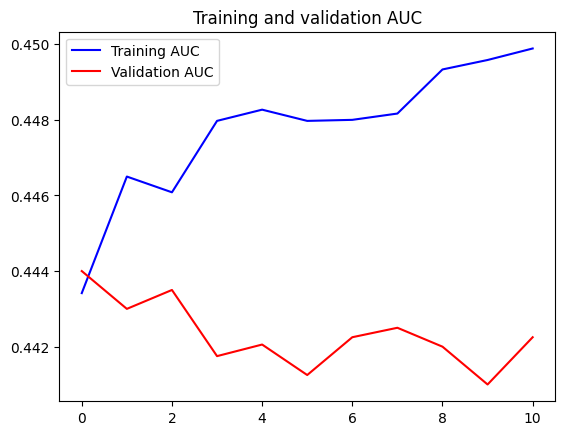

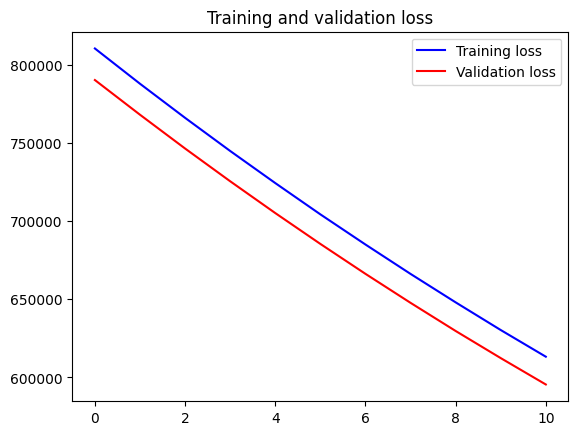

125/125 [==============================] - 7s 53ms/step
Calcul et affichage de la matrice de confusion


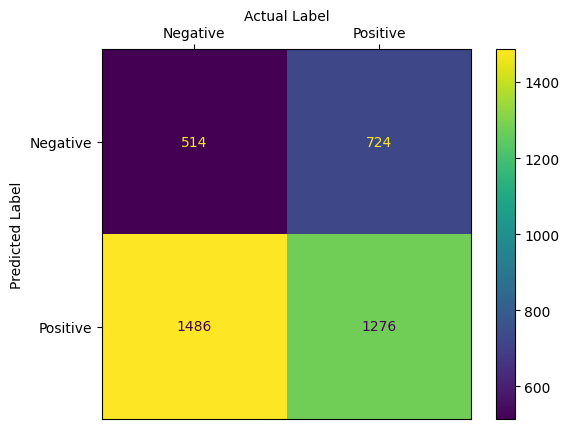

Spécificité : 0.257
Calcul et affichage des différentes métriques
Précision : 0.439
AUC : 0.448
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.42      0.26      0.32      2000
    Positive       0.46      0.64      0.54      2000

    accuracy                           0.45      4000
   macro avg       0.44      0.45      0.43      4000
weighted avg       0.44      0.45      0.43      4000

Execution time is: 552.0 s, soit 9.0 min, soit 0.0 h.
---------------------------------------------------------------------- Embedding model glove ----------------------------------------------------------------------
Found 1193514 word vectors.
Embedding Matrix Shape: (17695, 200)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 200)          3539000   
                           

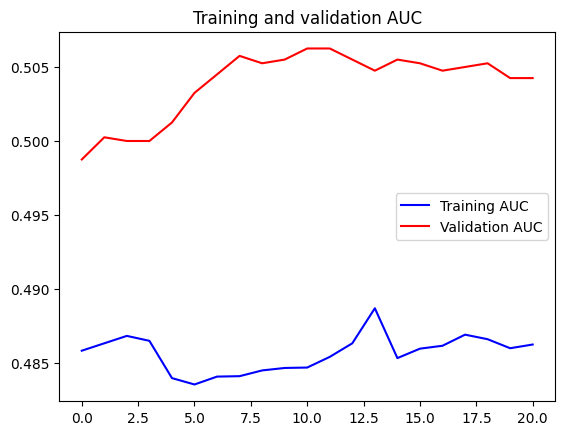

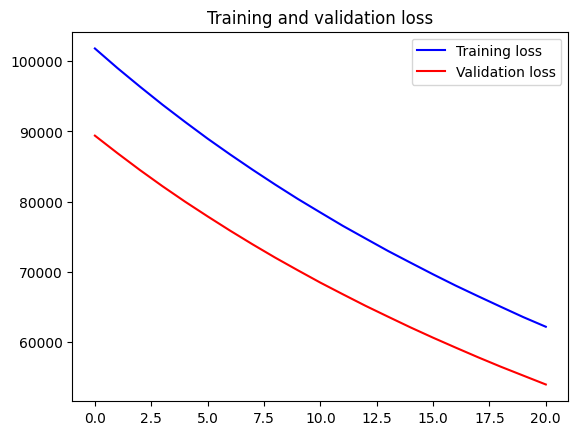

125/125 [==============================] - 3s 21ms/step
Calcul et affichage de la matrice de confusion


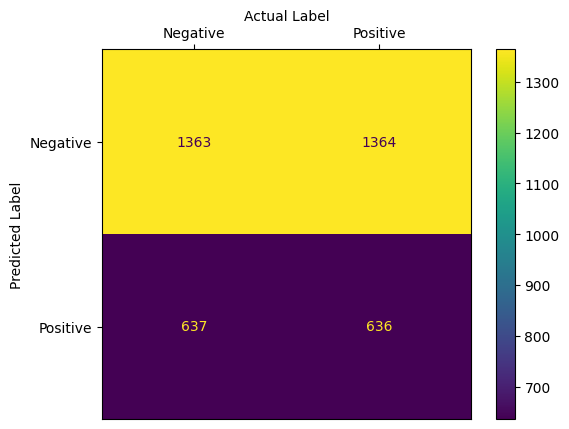

Spécificité : 0.6815
Calcul et affichage des différentes métriques
Précision : 0.5
AUC : 0.5
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.50      0.68      0.58      2000
    Positive       0.50      0.32      0.39      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.48      4000
weighted avg       0.50      0.50      0.48      4000

Execution time is: 313.0 s, soit 5.0 min, soit 0.0 h.


In [80]:
speci_res = {}
for word_embed_model in ["word2vec", "glove"]:
    start = time.time()
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_neural_network_model_auc(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model_auc(model, X_train, y_train, X_val, y_val)
    
    # show the result into a graph
    display_result_plot_auc(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    speci = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False, beta=1)
    display_classification_report(y_test, y_pred, display_labels=["Negative", "Positive"])
    
    speci_res[word_embed_model] = speci
    
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    # pickle.dump(model, open("models/mod_RNN_" + word_embed_model + ".h5", 'wb'))
    model.save("models/mod_RNN_" + word_embed_model + ".h5")
    keras.backend.clear_session()

In [81]:
speci_res

{'word2vec': 0.257, 'glove': 0.6815}

In [82]:
# from sklearn import model_selection
# from scikeras.wrappers import KerasClassifier
# # Function to create model, required for KerasClassifier
# def create_model():
#     # word embedding
#     embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name="glove")
#     vocab_size = len(tokenizer.word_index) + 1

#     # create embedding layer
#     embedding_layer = layers.Embedding(
#     input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
#     input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
#     # create model
#     model = keras.Sequential()
#     model.add(embedding_layer)
#     model.add(layers.Conv1D(128, 5, activation='relu'))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(16, activation="relu"))
#     model.add(layers.Dense(16, activation="relu"))
#     model.add(layers.Dense(1, activation="sigmoid"))
    
#     # on crée les fonctions de loss et d'optimisation
#     loss = losses.BinaryCrossentropy(from_logits=True)
#     optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
#     # on compile le modèle
#     model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
#     return model

In [83]:
# start = time.time()
# # create model
# model = KerasClassifier(model=create_model, verbose=0)
# # define the grid search parameters
# batch_size = [50, 100]
# epochs = [10, 20]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=15, cv=3, error_score='raise')
# grid_result = grid.fit(X_train, y_train)

In [84]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## LSTM

In [85]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [86]:
def create_lstm_neural_network_model(embedding_layer, init_scheme="ones"):
    # on crée la séquence avec toutes les couches de notre réseau de neurones
    model = keras.Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True, kernel_initializer=init_scheme, bias_initializer='zeros')),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True, kernel_initializer=init_scheme, bias_initializer='zeros')),
        Conv1D(100, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'),
        Dense(1, activation='sigmoid', kernel_initializer=init_scheme, bias_initializer='zeros'),
    ],
    name="Sentiment_Model")
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [87]:
def create_lstm_neural_network_model_auc(embedding_layer, init_scheme="ones"):
    # on crée la séquence avec toutes les couches de notre réseau de neurones
    model = keras.Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True, kernel_initializer=init_scheme, bias_initializer='zeros')),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True, kernel_initializer=init_scheme, bias_initializer='zeros')),
        Conv1D(100, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'),
        Dense(1, activation='sigmoid', kernel_initializer=init_scheme, bias_initializer='zeros'),
    ],
    name="Sentiment_Model")
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.AUC()])
    model.summary()
    
    return model

---------------------------------------------------------------------- Embedding model word2vec ----------------------------------------------------------------------
Embedding Matrix Shape: (17695, 800)
Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 800)          14156000  
                                                                 
 bidirectional (Bidirectiona  (None, 800, 200)         720800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 800, 200)         240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 796, 100)          100100    
                                             

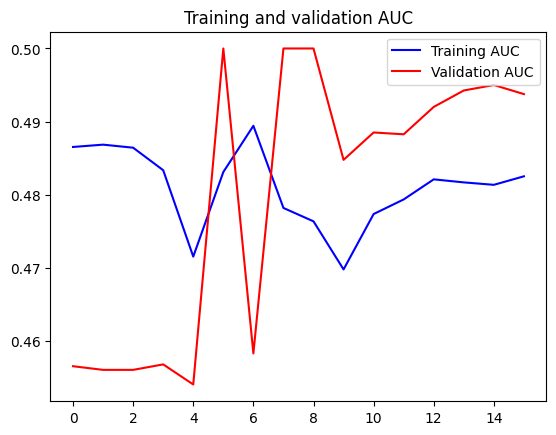

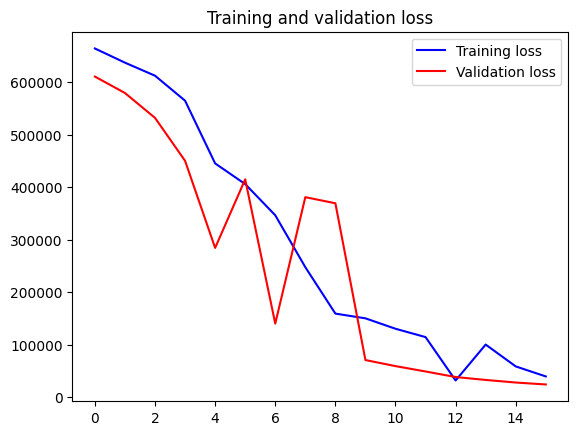

125/125 [==============================] - 30s 236ms/step
Calcul et affichage de la matrice de confusion


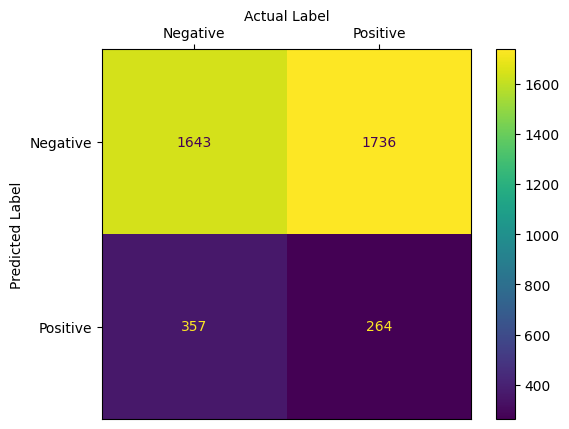

Spécificité : 0.8215
Calcul et affichage des différentes métriques
Précision : 0.456
AUC : 0.477
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.49      0.82      0.61      2000
    Positive       0.43      0.13      0.20      2000

    accuracy                           0.48      4000
   macro avg       0.46      0.48      0.41      4000
weighted avg       0.46      0.48      0.41      4000

Execution time is: 2819.0 s, soit 47.0 min, soit 1.0 h.
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirection

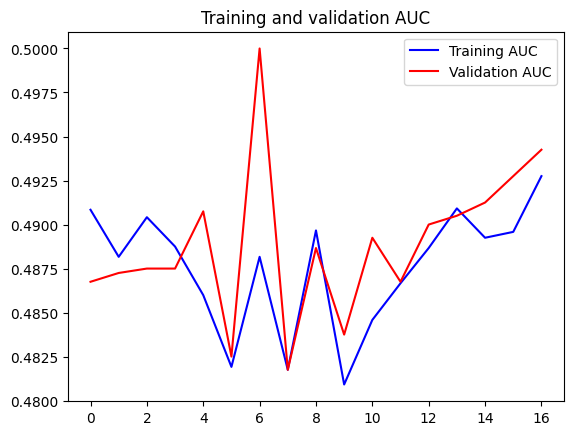

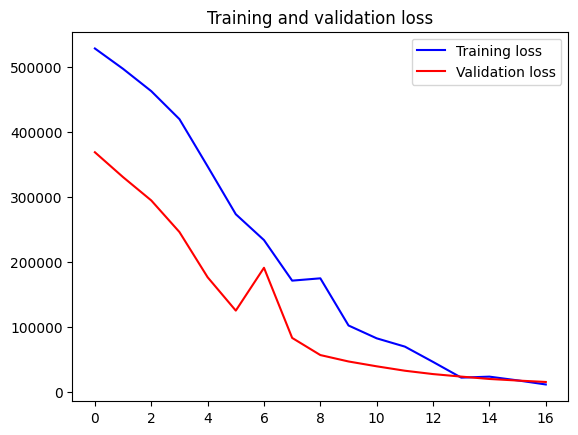

125/125 [==============================] - 23s 181ms/step
Calcul et affichage de la matrice de confusion


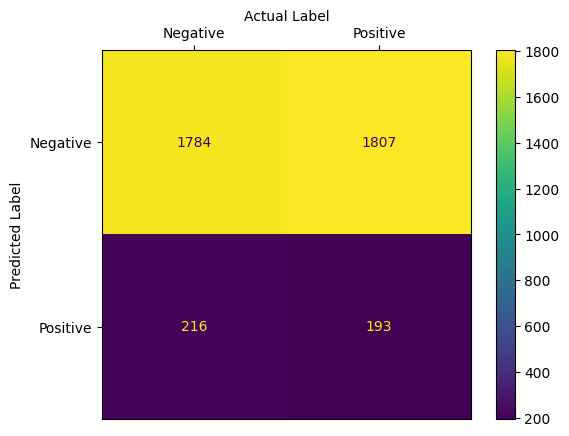

Spécificité : 0.892
Calcul et affichage des différentes métriques
Précision : 0.484
AUC : 0.494
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.50      0.89      0.64      2000
    Positive       0.47      0.10      0.16      2000

    accuracy                           0.49      4000
   macro avg       0.48      0.49      0.40      4000
weighted avg       0.48      0.49      0.40      4000

Execution time is: 2043.0 s, soit 34.0 min, soit 1.0 h.
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectiona

In [88]:
speci_res = {}

for word_embed_model in ["word2vec", "glove"]:
    start = time.time()
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_lstm_neural_network_model_auc(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model_auc(model, X_train, y_train, X_val, y_val)
    
    # show the result into a graph
    display_result_plot_auc(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    speci = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False, beta=1)
    display_classification_report(y_test, y_pred, display_labels=["Negative", "Positive"])
    
    speci_res[word_embed_model] = speci
    
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    pickle.dump(model, open("models/mod_LSTM_" + word_embed_model + ".h5", 'wb'))
    keras.backend.clear_session()

In [89]:
speci_res

{'word2vec': 0.8215, 'glove': 0.892}

## GRU

In [90]:
from tensorflow.keras.layers import GRU

In [91]:
def create_gru_neural_network_model(embedding_layer, init_scheme="ones"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'))
    # model.add(layers.Flatten())
    model.add(layers.GRU(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=False)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [92]:
def create_gru_neural_network_model_auc(embedding_layer, init_scheme="ones", activation="relu"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation=activation, kernel_initializer=init_scheme, bias_initializer='zeros'))
    # model.add(layers.Flatten())
    model.add(layers.GRU(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation=activation, kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=False)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.AUC()])
    model.summary()
    
    return model

---------------------------------------------------------------------- Embedding model word2vec ----------------------------------------------------------------------
Embedding Matrix Shape: (17695, 800)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 800)          14156000  
                                                                 
 conv1d (Conv1D)             (None, 796, 128)          512128    
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)           

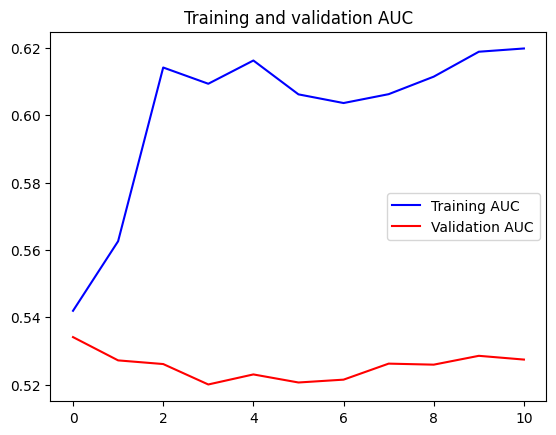

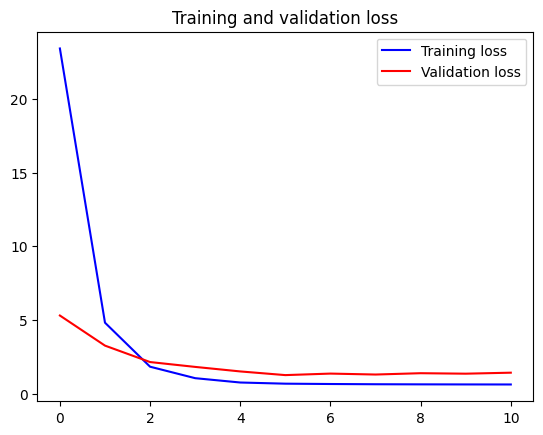

125/125 [==============================] - 11s 87ms/step
Calcul et affichage de la matrice de confusion


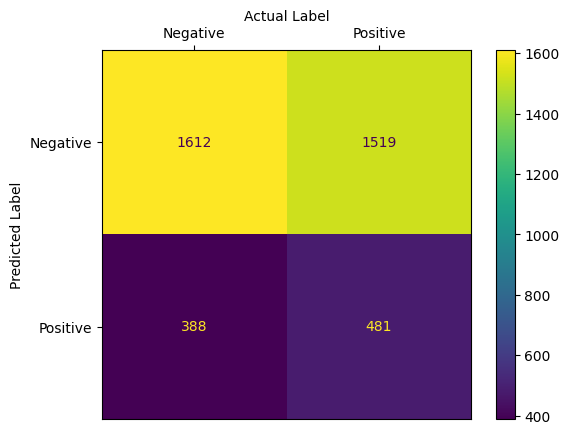

Spécificité : 0.806
Calcul et affichage des différentes métriques
Précision : 0.534
AUC : 0.523
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.51      0.81      0.63      2000
    Positive       0.55      0.24      0.34      2000

    accuracy                           0.52      4000
   macro avg       0.53      0.52      0.48      4000
weighted avg       0.53      0.52      0.48      4000

Execution time is: 799.0 s, soit 13.0 min, soit 0.0 h.
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
......gru
.........cell
............vars
...............0
...............1
...............2


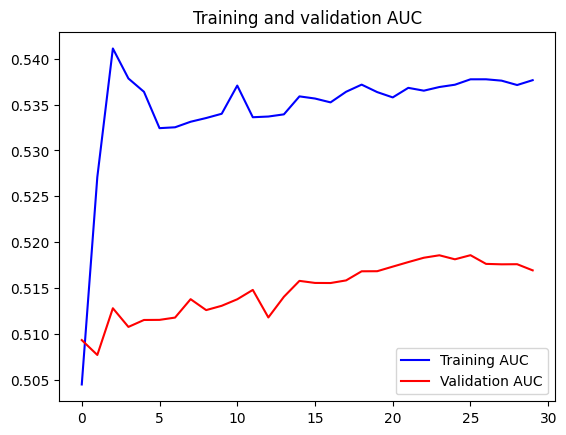

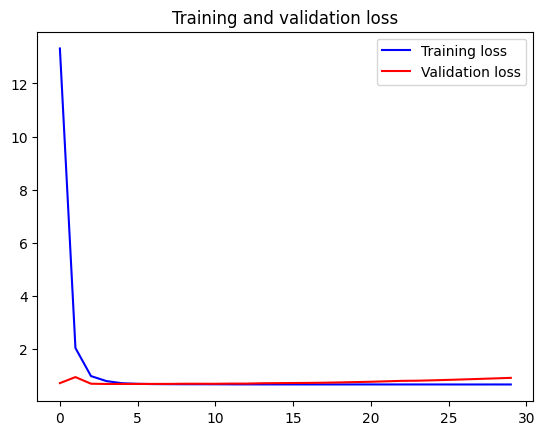

125/125 [==============================] - 7s 52ms/step
Calcul et affichage de la matrice de confusion


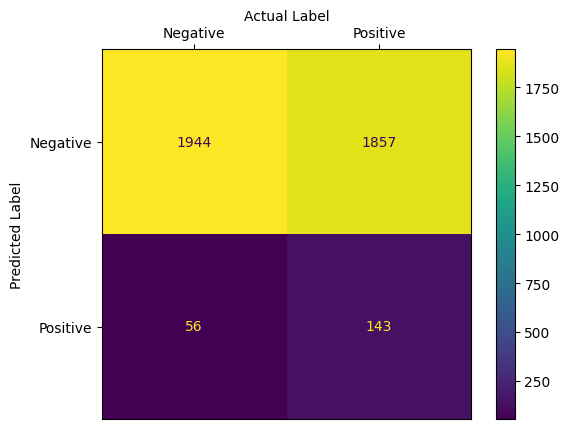

Spécificité : 0.972
Calcul et affichage des différentes métriques
Précision : 0.615
AUC : 0.522
Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

    Negative       0.51      0.97      0.67      2000
    Positive       0.72      0.07      0.13      2000

    accuracy                           0.52      4000
   macro avg       0.62      0.52      0.40      4000
weighted avg       0.62      0.52      0.40      4000

Execution time is: 1151.0 s, soit 19.0 min, soit 0.0 h.
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
......gru
.........cell
............vars
...............0
...............1
...............2

In [93]:
speci_res = {}

for word_embed_model in ["word2vec", "glove"]:
    start = time.time()
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_gru_neural_network_model_auc(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model_auc(model, X_train, y_train, X_val, y_val)
    
    # show the result into a graph
    display_result_plot_auc(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    
    speci = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False, beta=1)
    display_classification_report(y_test, y_pred, display_labels=["Negative", "Positive"])
    
    speci_res[word_embed_model] = speci
    
    end = time.time()
    delta = round(end - start, 0)
    print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    pickle.dump(model, open("models/mod_GRU_" + word_embed_model + ".h5", 'wb'))
    keras.backend.clear_session()

In [94]:
speci_res

{'word2vec': 0.806, 'glove': 0.972}

In [95]:
truc = bidule

NameError: name 'bidule' is not defined

# Optimisation

## GRU GridSearchCV

In [ ]:
from sklearn import model_selection
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model_gru():
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name="glove")
    vocab_size = len(tokenizer.word_index) + 1

    # create embedding layer
    embedding_layer = layers.Embedding(
    input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
    input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create model
    model = keras.Sequential()
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation="softmax", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
    model.add(layers.GRU(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation="softmax", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
          
    # on crée les fonctions de loss et d'optimisation
    # loss = losses.BinaryCrossentropy(from_logits=False)
    # optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    # optimizer = optimizers.Adagrad(learning_rate=0.2, epsilon=5e-07)
    
    # on compile le modèle
    # model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.AUC()])
    return model

In [ ]:
# batch_size = [50, 100, 150, 200]
# epochs = [10, 20, 30]
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# define the grid search parameters
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# param_grid = dict(batch_size=batch_size)
# param_grid = dict(optimizer=optimizer)

# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
learn_rate = [0.001]
epsilon = [0, 1e-07, 2e-07, 5e-07, 1e-06]
# epsilon = [1e-07]
# epsilon = [5e-07]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__epsilon=epsilon)

# init_mode = ['ones', 'uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(model__init_mode=init_mode)

# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(model__activation=activation)

In [ ]:
# loss = losses.BinaryCrossentropy(from_logits=False)
# optimizer = optimizers.Adamax(learning_rate=0.2, epsilon=5e-07)

In [ ]:
scoring = {
    'precision': 'average_precision',
    'AUC': 'roc_auc'
}

In [ ]:
start = time.time()
# create model
model = KerasClassifier(model=create_model_gru, verbose=0, epochs=10, batch_size=200, loss='binary_crossentropy', optimizer='Adamax')
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=17, cv=5, error_score='raise', scoring=scoring, refit='AUC')
grid_result = grid.fit(X_train, y_train)

In [ ]:
end = time.time()
delta = round(end - start, 0)
print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_prec = grid_result.cv_results_['mean_test_precision']
means_auc = grid_result.cv_results_['mean_test_AUC']
params = grid_result.cv_results_['params']
for mean_prec, mean_auc, param in zip(means_prec, means_auc, params):
    temp_sum = mean_prec + mean_auc
    print("Prec : %f - AUC : %f - Sum : %f with: %r" % (mean_prec, mean_auc, temp_sum, param))

In [ ]:
y_pred = grid.predict(X_test)
y_pred = np.where(y_pred>=0.5, 1, 0)

speci = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=True, beta=1)

In [ ]:
truc = bidule

### AUC Optimised GRU

In [ ]:
def create_gru_neural_network_model_opti(embedding_layer):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation="softmax", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
    # model.add(layers.Flatten())
    model.add(layers.GRU(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation="softmax", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=False)
    optimizer = optimizers.Adamax(learning_rate=0.001, epsilon=0)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [ ]:
# word embedding
embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name="glove")
vocab_size = len(tokenizer.word_index) + 1

# create embedding layer
embedding_layer = layers.Embedding(
    input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
    input_length=MAX_SENTENCE_LENGTH, trainable=False)

In [ ]:
start = time.time()

# create the neural network
model = create_gru_neural_network_model_opti(embedding_layer)

# train the neural network
history = train_neural_network_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=200)

# show the result into a graph
display_result_plot(history)

# compute confusion matrix and specificity
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>=0.5, 1, 0)

speci = display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
res = display_classification_metrics(model, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False, beta=1)
display_classification_report(y_test, y_pred, display_labels=["Negative", "Positive"])

end = time.time()
delta = round(end - start, 0)
print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
keras.backend.clear_session()